In [1]:
# !wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip

In [2]:
# !unzip -q Positive_tensors.zip

In [3]:
# ! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip

In [4]:
# !unzip -q Negative_tensors.zip

In [5]:
import torchvision.models as models
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os

# Setting the seed to 0 to get the same results at each run:
torch.manual_seed(0)

In [6]:
# Creating a dataset object:

class Dataset(Dataset):
    def __init__(self, transform=None, train=True):
        positive = 'Positive_tensors'
        negative = 'Negative_tensors'


        # Creating lists contanining concrete images with and without cracks on them:
        positive_files = [os.path.join(positive, file) for file in os.listdir(positive) if file.endswith('.pt')]
        # positive_files.sort()
        negative_files = [os.path.join(negative, file) for file in os.listdir(negative) if file.endswith('.pt')]
        # negative_files.sort()

        # Total number of images:
        number_of_samples = len(positive_files + negative_files)

        # Creating a list of placehodlers and assigning positive files to even and negative files to odd indexes:
        self.all_files = [None] * number_of_samples
        self.all_files[1::2] = negative_files
        self.all_files[::2] = positive_files
        self.transform = transform
        self.Y = torch.zeros([number_of_samples]).type(torch.LongTensor)
        # Setting the output categories to 0 as Negative and 1 as Positive images:
        self.Y[1::2] = 0
        self.Y[::2] = 1

        # The training of the model is done with 30000 images:
        if train:
            self.all_files = self.all_files[:30000]
            self.Y = self.Y[:30000]
            self.len = len(self.all_files)

        # The validation of the model is done with 10000 images:
        else:
            self.all_files = self.all_files[30000:]
            self.Y = self.Y[30000:]
            self.len = len(self.all_files)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        image = torch.load(self.all_files[index])
        y = self.Y[index]

        if self.transform:
            image = self.transform(image)

        return image, y
print('Done!')

Done!


In [7]:
train_dataset = Dataset()
validation_dataset = Dataset(train=False)
print('Done!')

Done!


In [8]:
# Defnining the ResNet18 model with default weights:
model = models.resnet18(weights='DEFAULT')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Preventing the parameters of the pretrained ResNet18 model from being updated:
for param in model.parameters():
    param.requires_grad = False

In [10]:
# Setting the final Fully Connected layer to ouput 2 classes:
model.fc = nn.Linear(in_features=512, out_features=2)
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [11]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# Using the Cross Entropy Loss as the loss function:
criterion = nn.CrossEntropyLoss()
criterion

CrossEntropyLoss()

In [13]:
# Creating trainining and validation loaders with batch size of 100 each:
train_loader = DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=100)

In [14]:
# Using Adam opzimization algorithm to update only the prameters that have not been frozen:
optimizer = torch.optim.Adam(params=[parameters for parameters in model.parameters() if parameters.requires_grad], lr=0.001)

In [15]:
n_epochs = 1
loss_list = []
accuracy_list = []
correct = 0
N_train = len(train_dataset)
N_test = len(validation_dataset)

Loss = 0
for epoch in range(n_epochs):
    # Training the model:
    for x, y in train_loader:
        # Setting the model to train mode:
        model.train()
        # Resetting the gradients:
        optimizer.zero_grad()
        yhat = model(x)
        loss = criterion(yhat, y)
        # Calculating the gradeints:
        loss.backward()
        # Updating the parameters:
        optimizer.step()
        # Saving the training loss data:
        loss_list.append(loss.data)
    correct=0
    # Validating the model:
    for x_test, y_test in validation_loader:
        # Setting the model to train mode:
        model.eval()
        yhat = model(x_test)
        _, yhat = torch.max(yhat, 1)
        correct += (yhat == y_test).sum().item()
    accuracy = correct / N_test
    # Saving the vaidation accuracy data:
    accuracy_list.append(accuracy)

In [16]:
# with open('resnet18_concrete_accuracy', 'w') as f:
#   f.write('Here is the accuracy of the ResNet18 after training with: Epoch=1, Learning Rate=0.001, Batch Size=100')
#   f.write(str(accuracy))

In [17]:
# model.load_state_dict(torch.load('/content/my_resnet18_classifier_dict_state.pth'))

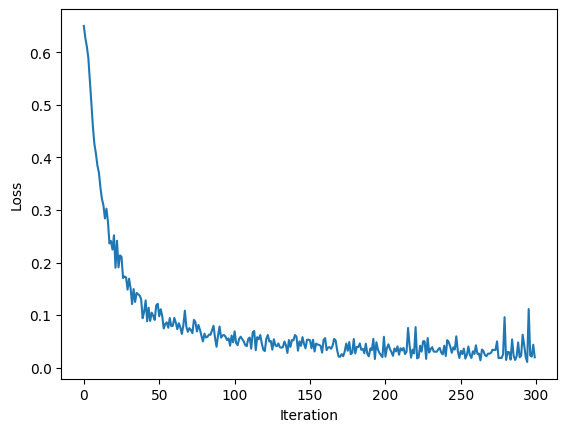

<Figure size 640x480 with 0 Axes>

In [18]:
# Plotting the loss data over iterations:
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()
plt.savefig('ResNet18 Loss Over Iterations.png')

In [19]:
# Plotting the first 5 misclassified images:
def plot_misclassified(model, dataset):
    count=0
    for x, y in dataset:
        # Unsqueezing the input tensor to match the model's input dimensions:
        z = model(x.unsqueeze(0))
        _, yhat = torch.max(z, 1)
        if yhat != y:
            # Rearranging the dimensions of the tensor for the imshow() method:
            x_plot = x.squeeze().permute(1, 2, 0)
            # Normalizing the image data as a range of [0, 1]:
            x_min = x_plot.min()
            range_val = x_plot.max() - x_min
            if range_val > 0:
                normalized_x = (x_plot - x_min) / range_val
            else:
                normalized_x = torch.zeros_like(x_plot)
            plt.imshow(normalized_x)
            plt.title(f'True label {y.item()}. Predicted label {yhat.item()}')
            plt.show()
            count+=1
        if count>=5:
            break

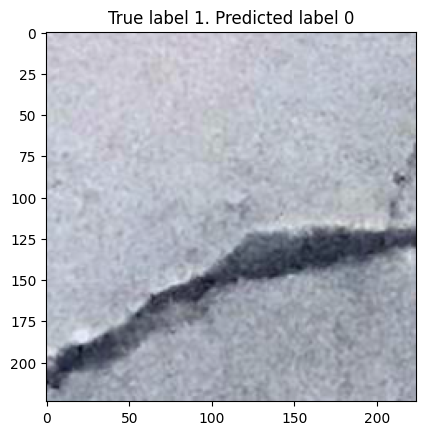

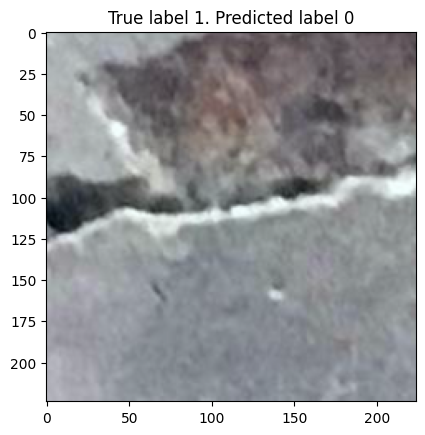

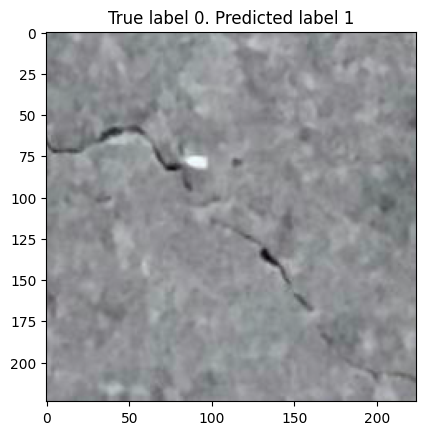

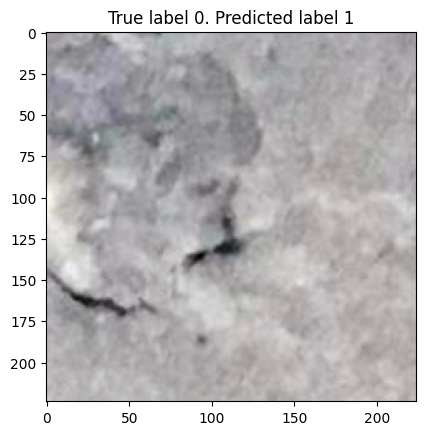

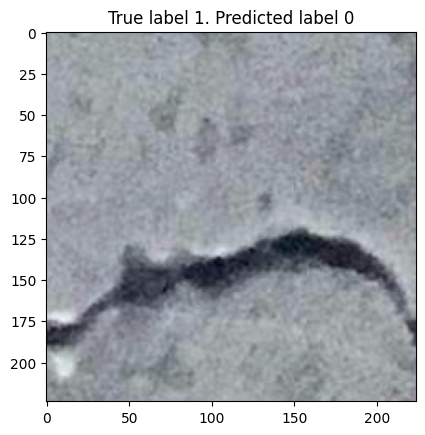

In [20]:
plot_misclassified(model=model, dataset=validation_dataset)

In [22]:
# Plotting the first 5 correctly classified images:
def correctly_classified(model, dataset):
    count=0
    for x, y in dataset:
        # Unsqueezing the input tensor to match the model's input dimensions:
        z = model(x.unsqueeze(0))
        _, yhat = torch.max(z, 1)
        if yhat == y:
            # Rearranging the dimensions of the tensor for the imshow() method:
            x_plot = x.squeeze().permute(1, 2, 0)
            # Normalizing the image data as a range of [0, 1]:
            x_min = x_plot.min()
            range_val = x_plot.max() - x_min
            if range_val > 0:
                normalized_x = (x_plot - x_min) / range_val
            else:
                normalized_x = torch.zeros_like(x_plot)
            plt.imshow(normalized_x)
            plt.title(f'True label {y.item()}. Predicted label {yhat.item()}')
            plt.show()
            count+=1
        if count>=5:
            break

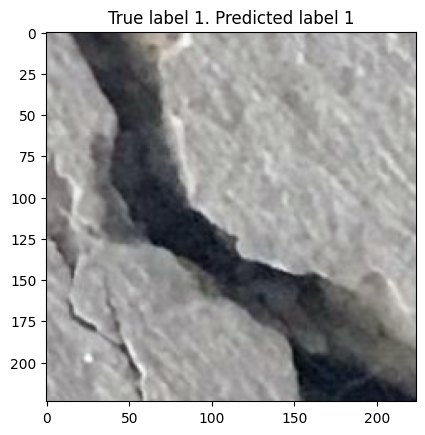

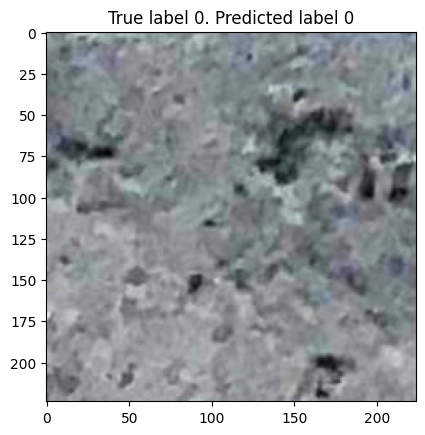

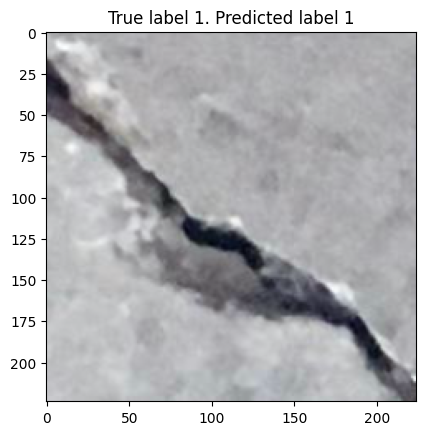

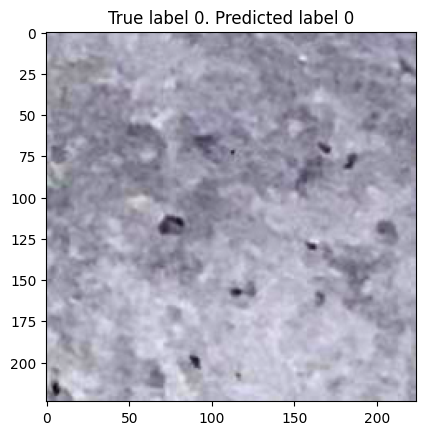

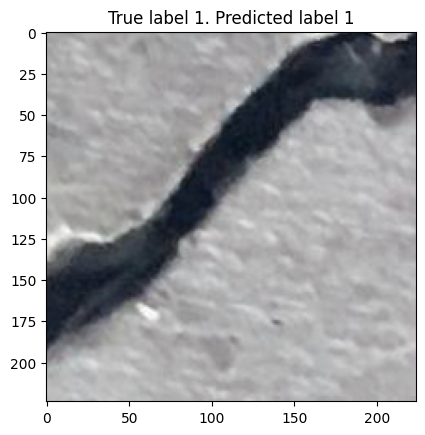

In [23]:
correctly_classified(model=model, dataset=validation_dataset)

In [25]:
# Saving the model's parameters state for future usage:
torch.save(obj=model.state_dict(), f='my_resnet18_classifier_dict_state.pth')